# Installation

In [1]:
! pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html

Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
     |████████████████████████████████| 2.6 MB 8.6 MB/s 
     |████████████████████████████████| 1.4 MB 29.0 MB/s 
     |████████████████████████████████| 926 kB 28.3 MB/s 
     |████████████████████████████████| 382 kB 40.9 MB/s 
     |████████████████████████████████| 222 kB 8.0 MB/s 
     |████████████████████████████████| 376 kB 13.8 MB/s 
     |████████████████████████████████| 45 kB 4.4 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.7.2-py3-none-any.whl size=388142 sha256=218c354f0bbc9efc6d6f780229d84a665c6f1c7ad3a0c92a0392a7d076ef2e0b
  Stored in directory: /root/.cache/pip/wheels/55/93/b6/2eeb0465afe89aee74d7a07a606e9770466d7565abd45a99d5
Successfully built torch-geometric


# Libraries

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T

from time import time
import matplotlib.pyplot as plt

# Forward Method

## Linear Transformation

$$\overline{h_i'} = W \ \overline{h_i}$$

where $W \in \mathbb{R}^{F' \text{x} F}$, $\overline{h_i} \in \mathbb{R}^{F}$ and $\overline{h_i'} \in \mathbb{R}^{F'}$

In [3]:
in_features = 5
out_features = 2
n_nodes = 3

W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
nn.init.xavier_uniform_(W.data, gain=1.414)

input = torch.rand(n_nodes,in_features) 

# Linear Transformation
h = torch.mm(input, W)
N = h.size()[0]

print(f"Input Shape: {input.shape}\nOtput Shape: {h.shape}")

Input Shape: torch.Size([3, 5])
Otput Shape: torch.Size([3, 2])


## Attention Mechanism

<center><img src="https://raw.githubusercontent.com/itsayushthada/Geometric-Machine-Learning/main/Graph-Deep-Learning/Images/03/AttentionMechanism.png" width=600> </img></center>

In [4]:
# Leaky RelU

leakyrelu = nn.LeakyReLU(0.2) 

<center><img src= "https://raw.githubusercontent.com/itsayushthada/Geometric-Machine-Learning/main/Graph-Deep-Learning/Images/03/a_input.png"> </img></center>

In [5]:
# Attention Matrix [Learnable Inner Product][Something like a Reimanninan Metric]
A = nn.Parameter(torch.zeros(size=(2*out_features, 1)))
nn.init.xavier_uniform_(A.data, gain=1.414)
print(f"Attention Matrix Sahpe: {A.shape}")

# Attention Matrix Inputs
A_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * out_features)
print(f"Attention Matrix Inputs Shape: {A_input.shape}")

# Unnormalized Attention Weights
e = leakyrelu(torch.matmul(A_input, A).squeeze(2))
print(f"Attention Attention Weights Shape: {e.shape}")

Attention Matrix Sahpe: torch.Size([4, 1])
Attention Matrix Inputs Shape: torch.Size([3, 3, 4])
Attention Attention Weights Shape: torch.Size([3, 3])


## Masked Attention

In [6]:
# Attention Masking Example
adj = torch.randint(2, (3, 3))
zero_vec  = -9e15*torch.ones_like(e)

attention = torch.where(adj > 0, e, zero_vec)

print(f"""Adjacancy Matrix: \n{adj.numpy()}\n
Unnoralized Attention Matrix: \n{e.clone().detach().numpy()}\n
Zero Matrix: \n{zero_vec.clone().detach().numpy()}\n
Attention: {attention.clone().detach().numpy()}""")

Adjacancy Matrix: 
[[1 1 1]
 [1 0 0]
 [0 0 1]]

Unnoralized Attention Matrix: 
[[-0.07364155 -0.01797769  0.52093667]
 [-0.17908764 -0.12342378 -0.00125875]
 [-0.3450346  -0.28937075 -0.16720572]]

Zero Matrix: 
[[-9.e+15 -9.e+15 -9.e+15]
 [-9.e+15 -9.e+15 -9.e+15]
 [-9.e+15 -9.e+15 -9.e+15]]

Attention: [[-7.3641554e-02 -1.7977690e-02  5.2093667e-01]
 [-1.7908764e-01 -8.9999998e+15 -8.9999998e+15]
 [-8.9999998e+15 -8.9999998e+15 -1.6720572e-01]]


In [7]:
# Masking Attention to Real Embedding

attention = F.softmax(attention, dim=1)
h_prime   = torch.matmul(attention, h)

print(f"h Tensor:\n{h.clone().detach().numpy()}\n\nh_prime Tensor:\n{h_prime.clone().detach().numpy()}")

h Tensor:
[[ 0.2666671   0.62609035]
 [-0.00232543  1.2960235 ]
 [ 1.3979753   0.9863958 ]]

h_prime Tensor:
[[0.7230149  0.9778795 ]
 [0.2666671  0.62609035]
 [1.3979753  0.9863958 ]]


# GAT Layer

In [8]:
class GATLayer(nn.Module):
    def __init__(self, in_channels, out_channels, dropout, alpha, concat=True):
        super(GATLayer, self).__init__()
        self.dropout       = dropout        # drop prob = 0.6
        self.in_features   = in_features    # 
        self.out_features  = out_features   # 
        self.alpha         = alpha          # LeakyReLU with negative input slope, alpha = 0.2
        self.concat        = concat         # conacat = True for all layers except the output layer.

        
        # Xavier Initialization of Weights
        # Alternatively use weights_init to apply weights of choice 
        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)
        
        self.A = nn.Parameter(torch.zeros(size=(2*out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)
        
        # LeakyReLU
        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, input, adj):
        # Linear Transformation
        h = torch.mm(input, self.W)
        N = h.size()[0]

        # Attention Mechanism
        A_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * self.out_features)
        e       = self.leakyrelu(torch.matmul(A_input, self.A).squeeze(2))

        # Masked Attention
        zero_vec  = -9e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        
        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime   = torch.matmul(attention, h)


        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime

# Modelling

In [9]:
name_data = 'Cora'
dataset = Planetoid(root= './tmp/' + name_data, name = name_data)
dataset.transform = T.NormalizeFeatures()

data = dataset[0]

print(f"Number of Classes in {name_data}:", dataset.num_classes)
print(f"Number of Node Features in {name_data}:", dataset.num_node_features)

Processing...
Done!
Number of Classes in Cora: 7
Number of Node Features in Cora: 1433


In [14]:
class GATModel(torch.nn.Module):
    def __init__(self, **kwargs):
        super(GATModel, self).__init__()
        self.hidden = 16
        self.in_head = 8
        self.out_head = 1
        self.dropout = 0.2
        
        self.conv1 = GATConv(in_channels = dataset.num_features, 
                             out_channels = self.hidden, 
                             heads = self.in_head, 
                             concat = True,
                             dropout = self.dropout)
        
        self.conv2 = GATConv(in_channels = self.hidden*self.in_head, 
                             out_channels = dataset.num_classes, 
                             concat = False, 
                             heads = self.out_head, 
                             dropout = self.dropout)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
                
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        
        return F.log_softmax(x, dim=1)

In [15]:
# Set Device

GPU = True

device = 'cuda' if torch.cuda.is_available() and GPU else 'cpu'
device

'cuda'

In [16]:
# Instantiate Model
model = GATModel()

# Put Model and Data on Device
model.to(device)
data.to(device)

# Instantiate Optimizer
adam = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [17]:
# Define Train and Evalaution Subroutine

EPOCHS = 1000
PATIENCE = 20
history = {"train-loss": [np.inf], "val-loss": [np.inf], "train-accuracy": [0], "val-accuracy": [0]}

min_loss = np.inf
es_counter = 0

for epoch in range(EPOCHS):
    tick = time()

    # Custom Train Loop
    model.train()
    adam.zero_grad()
    logits = model.forward(data)
    train_loss =  F.nll_loss(logits[data.train_mask], data.y[data.train_mask])
    train_loss.backward()
    adam.step()
    history["train-loss"].append(train_loss.item())

    # Custom Evaluation Loop
    model.eval()
    logits = model.forward(data)
    val_loss =  F.nll_loss(logits[data.val_mask], data.y[data.val_mask])
    history["val-loss"].append(val_loss.item())
    for mask_name in ['train', 'val']:
        _, mask = next(data(f"{mask_name}_mask"))
        pred = logits[mask].max(dim=1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        history[f"{mask_name}-accuracy"].append(acc)

    tock = time()

    # Early Stopping
    if min_loss < val_loss:
        es_counter += 1
    else:
        es_counter = 0
    
    if es_counter >= PATIENCE:
        print("Validation Loss Increasing. Early Stopping !!!")
        break
    
    # Print Results
    if (epoch)%50 == 0:
        print(f"""Epcohs: {epoch:03}/{EPOCHS}
    - Train Loss:{history["train-loss"][-1]: 0.6f} \t Train Accuracy: {history["train-accuracy"][-1]: 0.6f}
    - Valid Loss:{history["val-loss"][-1]: 0.6f} \t Valid Accuracy: {history["val-accuracy"][-1]: 0.6f}
    - Turnaround Time: {tock-tick: 0.6f} sec
        """)

    # Update Minimum Loss
    min_loss = min(*history["val-loss"])

Epcohs: 000/1000
    - Train Loss: 1.948031 	 Train Accuracy:  0.707143
    - Valid Loss: 1.927901 	 Valid Accuracy:  0.530000
    - Turnaround Time:  1.153891 sec
        
Epcohs: 050/1000
    - Train Loss: 0.435455 	 Train Accuracy:  0.985714
    - Valid Loss: 0.797207 	 Valid Accuracy:  0.800000
    - Turnaround Time:  0.007167 sec
        
Epcohs: 100/1000
    - Train Loss: 0.303380 	 Train Accuracy:  1.000000
    - Valid Loss: 0.677627 	 Valid Accuracy:  0.804000
    - Turnaround Time:  0.006959 sec
        
Validation Loss Increasing. Early Stopping !!!


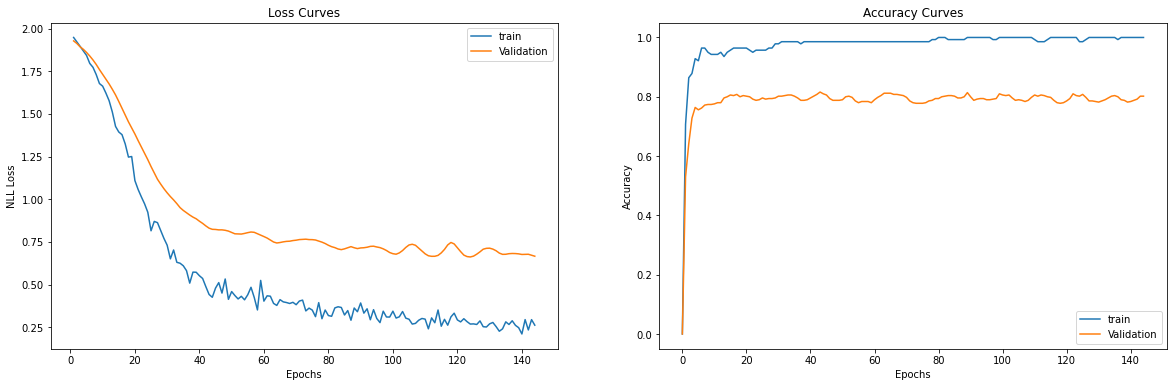

In [18]:
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.plot(history["train-loss"], label="train")
plt.plot(history["val-loss"], label="Validation")
plt.xlabel("Epochs")
plt.ylabel("NLL Loss")
plt.title("Loss Curves")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["train-accuracy"], label="train")
plt.plot(history["val-accuracy"], label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curves")
plt.legend()

plt.show()